## Lottery tickets visual checker.

In this notebook I demonstrate an example of visual recognition and checking a lottery ticket against the numbers that came out.<br>

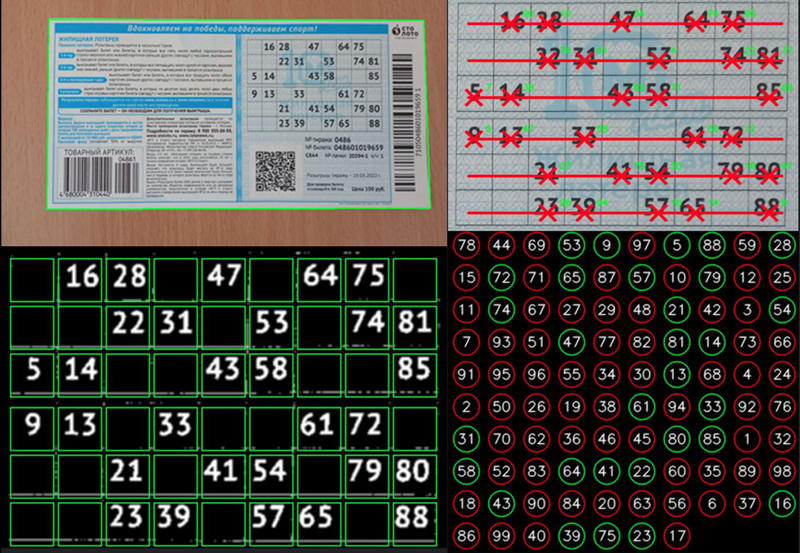


The essence of this series of lotteries is the following:<br>the tickets are already preprinted with a unique set of unique numbers in a range from 1 to 99. The numbers are randomly distributed on two tables of size 3 * 9. The ticket contains a total of 30 digits, so the tables contain empty cells distributed in random order.<br>
When the lottery starts, the host takes out 97 "barrels" of numbers, one by one, and each holder crosses out that number in their tickets, if it is present. If the entire horizontal line is filled out, it brings additional scores.<br>

Each sub-lottery in this series has sophisticated rules how to calculate scores, but I will focus on the computer vision aspect.<br>


It is common practice to cross out the dropped numbers with a pencil or pen, but now I want to make the process more digital... <br>
My script is designed to replace the process of manual crossing using a pen, just by using any smartphone with camera.

## Content
### 1. Utility functions
* 1.1 Image preprocessing and full area of insetest extraction
* 1.2 Small ROIs coordinades calculation for each cell
* 1.3 ROI extraction and OCR'ig
* 1.4 Test
* 1.5 Draw

### 2. Functions applying
### 3. Game simulation mode
### 4. Game interactive mode

In [1]:
!pip install imutils
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from easyocr import Reader
from datetime import datetime

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=24e5d63d942523f513a9ea078aaa38c6f63d4919eb1711c55abc493aba2092b7
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


#### Helper function to plot images with matplotlib

In [2]:
def show(image,H = 15, W = 20):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    if len(image.shape) == 2:
        plt.imshow(image, cmap = 'gray')
    else:
        plt.imshow(image)
    plt.show()

#### Load images (picture taken by smartphone)
As you can see there are five pictures of different tickets taken by **smartphone camera**, not by desktop scanner. Let's pick any of them:

One sample:


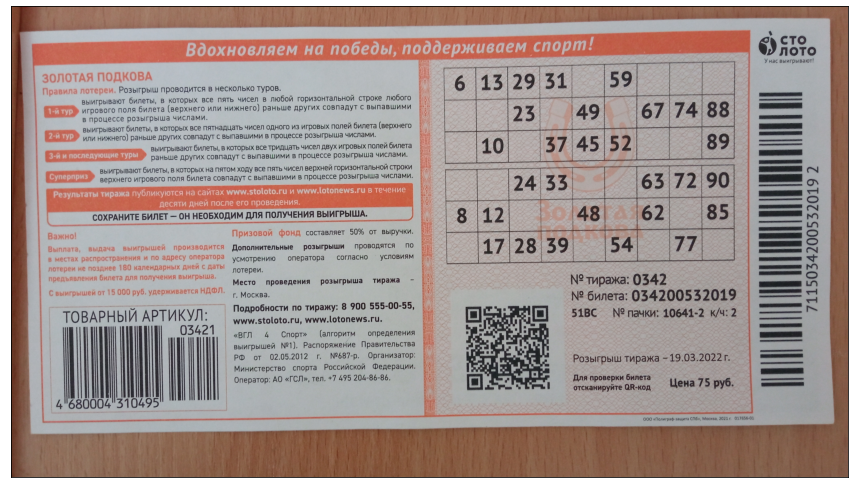

In [3]:
images = []
for dirname, _, filenames in os.walk('../input/loto-tickets/'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))

path = images[np.random.randint(len(images))]
sample = cv2.imread(path)
print("One sample:")
show(sample)

#### Full area of interest extracting (two tables with digits)
This fuction is to extract area of interest and preprocess it for the further OCR'ing

In [4]:
def extract (img):
    image = img.copy()
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    #Image resising by imutils
    image = imutils.resize(image, height = 500)
    
    #Convert to grayscale, apply bluring and canny edge
    #detection for further contours detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 50, 200)
    
    #Contours detection
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #Sort contours in descending orders, keep only five largest
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    
    #Apply contour approximation to simplify its shape
    for c in cnts:
        perim = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * perim, True)
    
    #Then select the largest (first) quadrangle contours (which has 4 vertexes)
        if len(approx) == 4:
            screenCnt = approx
            break
    #Ticket extraction and resizing
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    resized = imutils.resize(warped, width = 1000)
    
    #As now I have ticked in rectangular shape and as I know its size
    #I can manually define area of interest coordinates and size
    x, y = 515, 45
    h, w = 255, 380
    
    #Crop image to extract the full ROI
    croped = resized[y:y+h, x:x+w, :]
    clean = croped.copy()
    
    #Convert to grayscale, apply inversed thresholding and bluring
    #to make OCR possible
    croped = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
    _, t_holded = cv2.threshold(croped,100,255,cv2.THRESH_BINARY_INV)
    blured = cv2.GaussianBlur(t_holded, (3, 3), 0)
    
    if DEBUG:
        print('Original image:')
        show(orig)
        print('Detected ticket contour:')
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
        show (image)
        print('Extracted ticket:')
        show(warped)
        print('Extracted area of interest:')
        show(clean)
    
    #Finally returning BW and color pictures both
    return blured, clean

#### ROI generating to catch all cells from both tables

Here I calculate coordinates of ROI (regions of interest) for each cell.<br>
Again, as I know the image size, this is just an arithmetics.

In [5]:
#ROI location constants
x0, y0 = 10, 12
dX, dY = 40, 40
W, H = 36, 36

def find_ROI(image = None):
    
    ROI = []
    
    #Calculate ROI for the top table
    for i in range(3):
        for j in range(9):
            startX = x0 + (dX * j)
            startY = y0 + (dY * i)
            endX = startX + W
            endY = startY + H
            ROI.append((startX, startY, endX, endY))
            
    #Calculate ROI for the bottom table
    y1 = y0 + 125
    
    for i in range(3):
        for j in range(9):
            startX = x0 + (dX * j)
            startY = y1 + (dY * i)
            endX = startX + W
            endY = startY + H
            ROI.append((startX, startY, endX, endY))
            
    #Show ROIs in debugging mode
    if DEBUG and image is not None:
        img = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
        for i in range(len(ROI)):
            cv2.rectangle(img, ROI[i][0:2], ROI[i][2:4], (0,255,0), 1)
        print('ROIs (green):')
        show(img)
    
    return ROI

### OCR'ing all cells that are not empty
In this function I extract all small ROI one by one, check if it's not empty (by mean brigtness) and apply OCR.<br>
Here I use ```easyocr``` , this really EASY OCR module to implement, just two lines of code !

In [6]:
# Initialize EasyOCR reader
#(the first line of the easyocr code)
reader = Reader(['en'])

def OCR (img, ROI):
    #Create an empty numpy array for recognized data
    OCRed = np.full((54), np.NaN)
    
    #Check all cells one by one
    for i in range(len(ROI)):
        img2 = img[ROI[i][1] : ROI[i][3], ROI[i][0] : ROI[i][2]]
        img2 = clear_border(img2)
        
        #OCR if cell is not emtpy
        if img2.mean() > 10:
            #(the second line of the easyocr code)
            result = reader.readtext(img2)
            #Error if not OCR'ed
            if not result:
                print('Cannot OCR, please try another image')
                return
            else:
                res = result[0][-2]
            
            #If OCRed value is numeric and in the valid range,
            #append it to the array
            if res.isnumeric() and (1 <= int(res) <= 99):
                OCRed[i] = res
            
            #Stop otherwise
            else:
                print('Cannot OCR, please try another image')
                return

    #Array reshape to fit tables (totally 6 rows by 9 columns)
    OCRed = OCRed.reshape((6,9))
    
    if DEBUG:
        print('Recognized:')
        
        #Using pandas for [more nicely] output in html
        df = pd.DataFrame(OCRed, index = range(1,7), columns = range(1,10))
        df = df.fillna(0)
        df = df.astype(int).replace(0,'')
        display(df)
    
    return OCRed   

### Check that all recognized numbers are valid
As it is possible that the numbers are not recognized correctly, additional verification is needed.<br>
Here I check that:
1. Every row contains exactly 5 numbers
1. All numbers are in valid range
1. there are 30 numbers and all of them are unique

In [7]:
def check (ocr):
    #Check number of recognized digits in every row
    nums = np.zeros((6,5), np.float32)
    for i in range (6):
        x = ocr[i,:]
        y = x[~np.isnan(x)]
        if len(y) == 5:
            nums[i] = y
        else:
            print('Less than 5 digits at least in one of the rows')
            return
        
    #Check range
    if not (1 <= nums.all() <= 99):
        print ('Digits is out of range 1-99')
        return
    
    #Check uniqueness
    if np.unique(nums).shape[0] < 30:
        print ('Less than 30 unique digits')
        return
    
    print('Test passed, ready for the game !')
    return 

### Function to draw red crosses on matched numbers and to draw lines if any of horizontal lines are fully matched
This function is not related to recognition, this is to visualize how the popped out numbers (and lines) are "crossing out".<br> It uses just simple arithmetics and openCV basic drawing finctions<br>

In [8]:
def draw (img, roi, nums, selected, count):
    
    #OpenCV antialiased linetype
    line = cv2.LINE_AA
    
    #Check if number is presented in the ticket
    matched = selected in nums
    
    
    #Draw circle with popped number
    #Circle color
    if matched:
        color = (0, 255, 0) #Green
    else:
        color = (0, 0, 255) #Red
    
    #Circle coords
    c_X = 20 + (38 * (count % 10))
    c_Y = 270 + (35 * (count // 10))
    cv2.circle(img,
               (c_X, c_Y),
               radius = 14,
               color = color,
               thickness = 1,
               lineType=line)
    
    #Put number inside the circle
    
    #Centering for one-digit numbers
    bias = selected < 10
    
    cv2.putText(img,
            str(selected),
            org = (c_X - 10 + bias * 5,
                   c_Y + 5),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 0.5,
            color = (255, 255, 255),
            thickness = 1,
            lineType=line)

    #If mismatched
    if not matched:
        return img, nums, matched
    
    #If number presented:
    
    #Find ROI index
    idx = np.where(recognized == selected)
    
    #Remove matched number to avoid double detection
    nums[idx] = np.NaN
    
    #Find ROI location
    idx = [idx[0][0], idx[1][0]]
    coord = idx[0] * 9 + idx[1]
    cross = ROI[coord]
    
    #Margin to draw crosses and lines nicely
    margin = 10
    
    #Cross coordinates calculation
    top_left = (cross[0] + margin, cross[1] + margin)
    top_right = (cross[2] - margin, cross[1] + margin)
    bottom_right = (cross[2] - margin, cross[3] - margin)
    bottom_left = (cross[0] + margin, cross[3] - margin)
    
    #Cross drawing
    cv2.line(img, top_left, bottom_right, (0,0,255), 2, lineType=line)
    cv2.line(img, top_right, bottom_left, (0,0,255), 2, lineType=line)
    
    #Counter coordinates
    cnt_X = cross[2] - 5
    cnt_Y = cross[1] + 10
    
    #Add counter text
    cv2.putText(img,
                str(count + 1), #Start counting from 1, not form 0
                org = (cnt_X, cnt_Y),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.3,
                color = (0, 255, 0),
                thickness = 1,
                lineType=line)
    
    #Check if any of horizontal lines is full, draw the red line if yes
    for i in range(nums.shape[0]):
        if (np.isnan(nums[i]).all()):
            
            #Line coordinates calculation
            startX = y0 + i*dX + H//2 + i//3 * 5
            endX =  y0 + i*dX + H//2 + i//3 * 5
            startY = y0 + margin
            endY = y0 + dY*9  - margin
            
            #Line drawing
            cv2.line(img, (startY, startX), (endY, endX), (0,0,255), 2)
            
            #Record zeros in array not to detect filled line again
            nums[i] = 0
            
    return img, nums, matched

#### Debugging mode activation
Switch ```DEBUG``` to *False* to hide intermediate outputs

In [9]:
DEBUG = True

### Run
Now I'm applying all functions one by one

Original image:


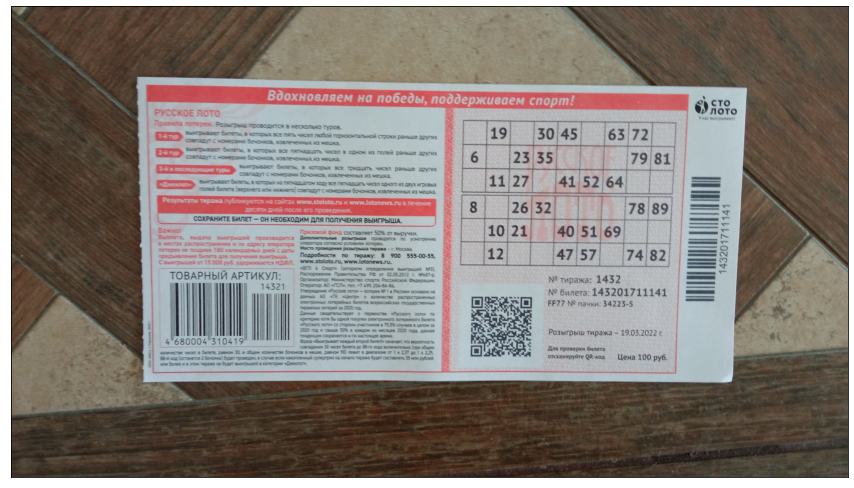

Detected ticket contour:


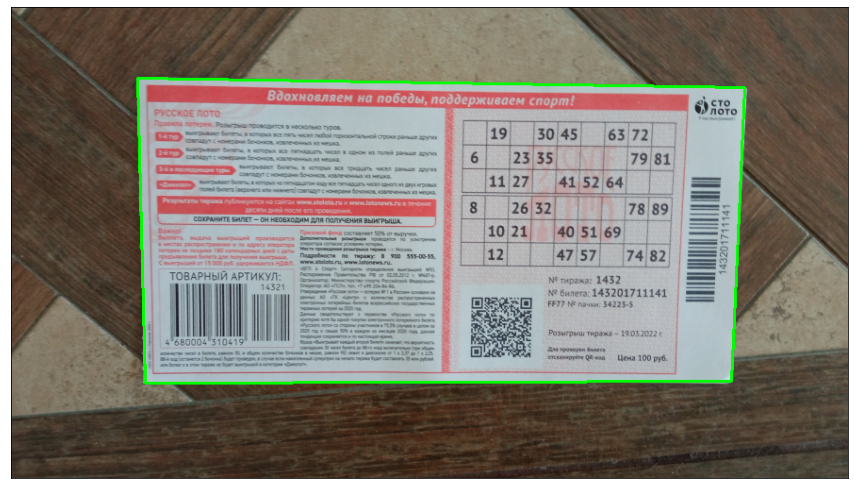

Extracted ticket:


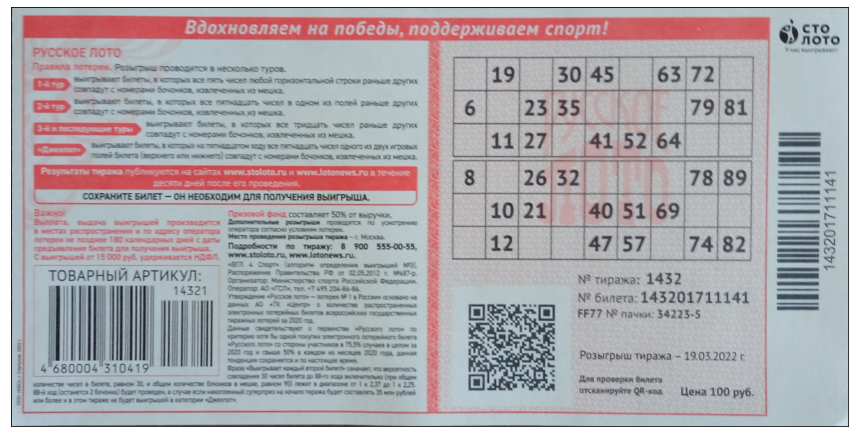

Extracted area of interest:


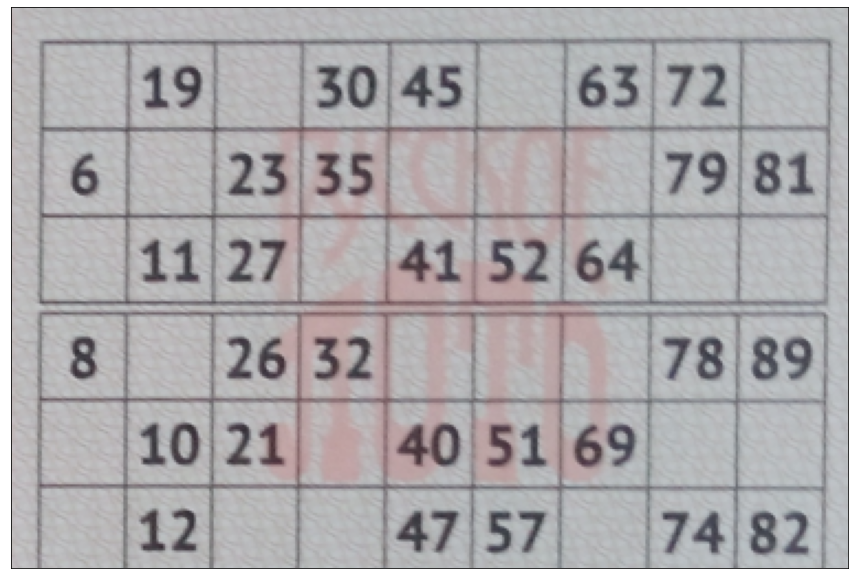

ROIs (green):


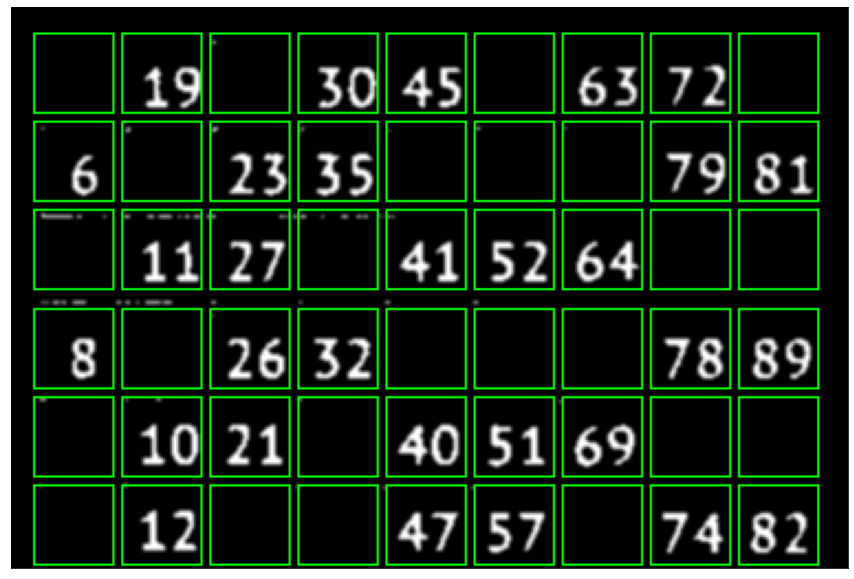

Recognized:


1   2   3   4   5   6   7   8   9
1     19      30  45      63  72    
2  6      23  35              79  81
3     11  27      41  52  64        
4  8      26  32              78  89
5     10  21      40  51  69        
6     12          47  57      74  82

Test passed, ready for the game !


In [10]:
#Pick random picture from the input folder
path = images[np.random.randint(len(images))]
img = cv2.imread(path)

#Ticket and full ROI area extraction
extracted, clean = extract(img)
#Small ROI defenition
ROI = find_ROI(extracted)
#Extract and OCR all small ROIs
recognized = OCR(extracted, ROI)
#Additional test if OCR'ed
if recognized is not None:
    check(recognized)

## Game simulation mode
In this mode I simulate some random numbers that was virtually 'popped out" and demonstrate how the vizualisation is working.<br>
You can change ```SIMULATE``` variable for different quantity of "popped out" numbers.

Total matched: 30 out of 97 

Matched numbers: [47, 19, 63, 10, 21, 12, 26, 79, 52, 11, 57, 40, 35, 64, 81, 27, 78, 6, 51, 32, 74, 8, 69, 72, 30, 82, 23, 45, 41, 89] 

Mismatched numbers: [54, 83, 14, 66, 94, 56, 61, 76, 85, 38, 90, 70, 3, 55, 84, 60, 96, 99, 28, 50, 34, 16, 9, 36, 58, 93, 48, 20, 43, 37, 91, 15, 42, 67, 87, 46, 68, 2, 4, 5, 59, 22, 73, 77, 86, 39, 24, 44, 71, 13, 49, 80, 92, 62, 53, 25, 17, 75, 18, 33, 29, 1, 7, 65, 97, 88, 95] 

Lines closed: 6


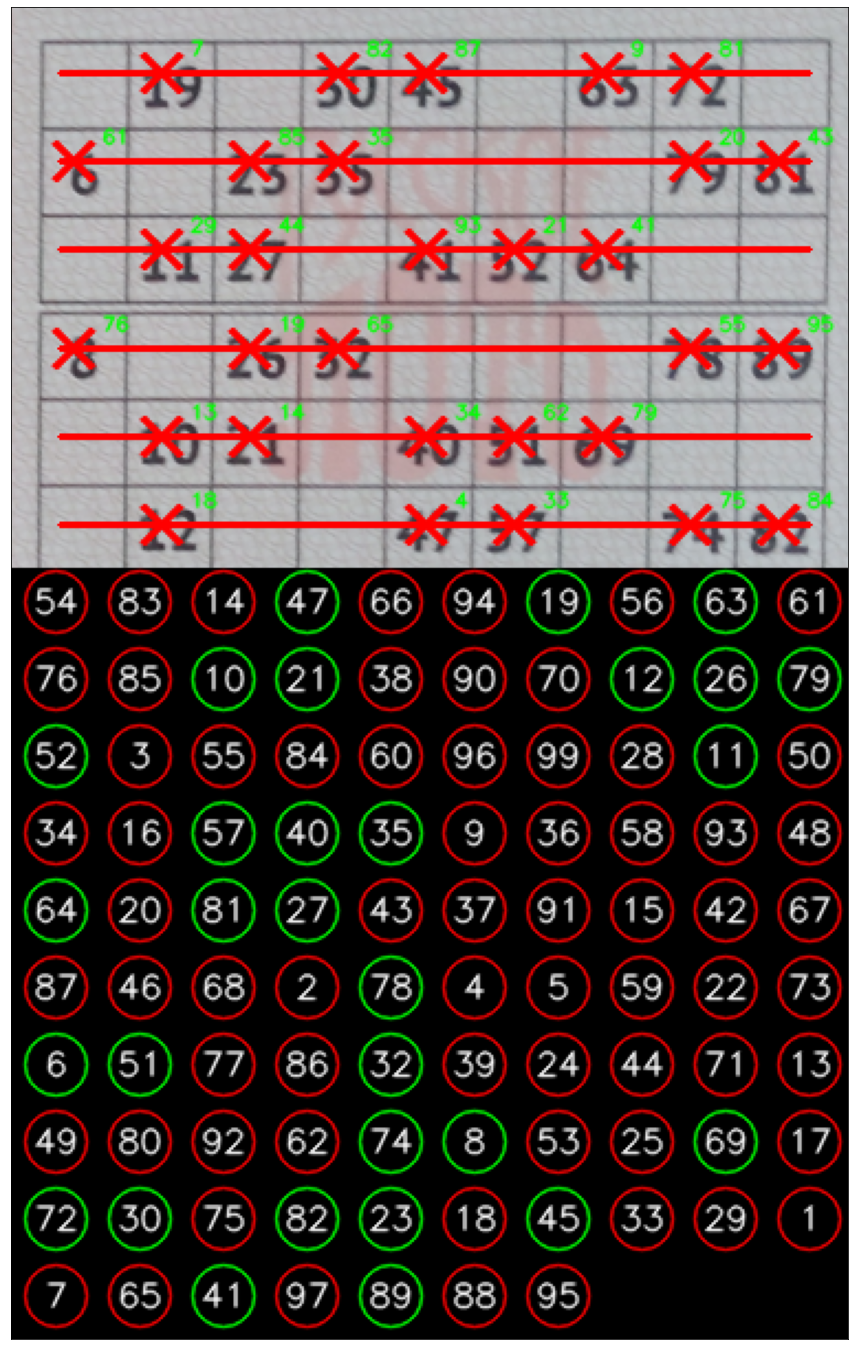

In [11]:
#Create empty picture and put ticket at the top of it
#Bottom space will be used to display numbers are popping
ticket = np.zeros((clean.shape[0] + 350, clean.shape[1],3 ), np.uint8)
ticket[:clean.shape[0], :clean.shape[1]] = clean
ticket_nums = recognized.copy()

#Empty lists for stats
matched, mismatched = [], []
lines = 0

#Generate some random numbers
SIMULATE = 97 #Simulation sequence length
simulation = np.random.choice(range(1, 100), SIMULATE, replace=False)

for i in range(len(simulation)):
    #Draw crosses and lines
    ticket, ticket_nums, result = draw (ticket, ROI, ticket_nums, simulation[i], i)
    #Stats
    if result:
        matched.append(simulation[i])
    else:
        mismatched.append(simulation[i])

#Stats
lines = (ticket_nums == 0).all(axis=1).sum()
print('Total matched:', len(matched), 'out of',
      len(simulation), '\n')
print('Matched numbers:', matched, '\n')
print('Mismatched numbers:', mismatched, '\n')
print('Lines closed:', lines)
show(ticket, W=25)

## Interactive mode
In this mode, you can manually input the numbers and see how the relevant cells and lines are crossed out on the ticket<br>
Switch ```INTERACTIVE``` to *True* to activate interactive mode

In [12]:
INTERACTIVE = False

In [13]:
if INTERACTIVE:
    ticket = np.zeros((clean.shape[0] + 350, clean.shape[1],3 ), np.uint8)
    ticket[:clean.shape[0], :clean.shape[1]] = clean
    ticket_nums = recognized.copy()
    counter = 0
    selected = []
    
    while True:
        clear_output()
        show(ticket, W=25)
        inp = input('Please input the number or press X for exit or S to save ticket :')
        
        if inp in ['x', 'X', 'х', 'Х']:
            print('\n', 'Game over...')
            break
            
        if inp in ['s', 'S']:
            output = imutils.resize(ticket, width = 1200)
            cv2.imwrite('ticket ' + str(datetime.now())[:19] + '.jpg', output)
            print('\n', 'Ticked saved')
            time.sleep(1)
            
        if inp.isnumeric() and (1 <= int(inp) <= 99):
            if inp in selected:
                print(inp, 'was already selected, try again')
                time.sleep(2)
                continue
                
            selected.append(inp)
            
            ticket, ticket_nums, result = draw (ticket, ROI, ticket_nums, int(inp), counter)
            counter += 1
            if result == False:
                print('\n', 'No new matches found...', '\n')
                time.sleep(1)
            else:
                print('\n', 'New match found !!!')
                time.sleep(1)
        else:
            print('\n', 'Invalid range. Please input number in range 1-99')
            time.sleep(2)
            continue

### Thank you for your attention !